In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from concorde.tools import from_mag_to_uv, stormDir, forwardSpeed, geoDistKM
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm as tqdm
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = Path(r'../data/probabilisticPredictions')

In [3]:
dctTracks = pd.read_pickle(path/'tracksNC_with100perturbations_predTides.pkl')

#### Preprocess climada tracks

In [4]:
ys = [36.183, 35.795, 35.209, 34.717, 34.227, 34.213]
xs = [-75.745, -75.549, -75.704, -76.67, -77.953, -77.787]
names = ['duck', 'oregon', 'hatteras', 'beaufort', 'wilmington', 'wrightsville']

In [5]:
mask = gpd.read_file(r'../gis/gpkg/polygon_coastline_NC.gpkg')
def radImpact(vmax, rmax, vr = 33, beta = 1):
    r1 = rmax
    if rmax == 0:
        return 1
    else:
        while True:
            r = rmax * (vr / vmax)**(-2 / beta) * (np.exp(1 - (rmax / r1)**beta))**(1 / beta)
            if np.abs(r - r1) < 1e-5:
                break
            r1 = r
        if r == 0:
            return rmax
        else:
            return r

In [8]:
## Compute extra parameters and select portion of the track to match the trained data shape
## using the area of influence

## pert000 is the original track
dctTracksProcess = {}
for k in tqdm(dctTracks.keys()):
    for p in range(100):
        aux = dctTracks[k][[f'lon_pert{p:03d}', f'lat_pert{p:03d}', f'max_sustained_wind_pert{p:03d}', 
                                   f'central_pressure_pert{p:03d}', f'radius_max_wind_pert{p:03d}']]
        aux.columns = ['lon', 'lat', 'wind_speed', 'pressure', 'rad_to_max_ws']
        aux['wind_speed'] = [x/1.94384 for x in aux['wind_speed'].values]
        aux[f'heading_dir'] = stormDir(aux)
        aux[f'forward_speed'] = forwardSpeed(aux)
        
        for ntg, xtg, ytg in zip(names, xs, ys):
            d = [geoDistKM(ytg, xtg, (y, x)) for x, y in zip(aux['lon'], aux['lat'])]
            aux[f'dist_to_{ntg}'] = d
        ## repeat 2nd value of heading dir and forward speed on first row
        aux.iloc[0, 5] = aux.iloc[1, 5]
        aux.iloc[0, 6] = aux.iloc[1, 6]

        u, v = from_mag_to_uv(aux['forward_speed'], aux['heading_dir'], meteo = False)
        aux['forward_speed_u'] = u
        aux['forward_speed_v'] = v

        if p == 0:
            ri = [radImpact(aux.loc[i, 'wind_speed'], aux.loc[i, 'rad_to_max_ws']) for i in aux.index]
            inter = []
            for i, r in zip(aux.index, ri):
                pnt = Point((aux.loc[i, 'lon'], aux.loc[i, 'lat']))
                pol = pnt.buffer(r/110)
                if mask.iloc[0].geometry.intersects(pol):
                    inter.append(1)
                else:
                    inter.append(0)

            aux['windIntersectNC'] = inter
            indEnter = list(aux['windIntersectNC']).index(1) ## 1st time step with intersection
            indStart = max(indEnter - 4*24, 0) ## 4 days and 24 time steps per day
            indLeave = len(aux) - 1 - list(aux['windIntersectNC'])[::-1].index(1)
            indFinish = min(indLeave + 1*24, len(aux) - 1) ## 1 day and 24 time steps per day
            auxShort = aux.iloc[indStart:indFinish, :]
            aux = aux.drop(['windIntersectNC'], axis = 1)

        
        Xfft = np.abs(np.fft.fft(aux.loc[auxShort.index, :].values, axis = 1))
        dfFFT = pd.DataFrame(index = auxShort.index, columns = [f'{col}_fft' for col in aux.columns],
                            data = Xfft)
        
        dfTides = pd.DataFrame(dctTracks[k].iloc[:, -6:].values, columns = [x.capitalize() for x in names], index = aux.index)
        dfTides = dfTides.loc[auxShort.index, :]
        ### need to fix this
        dfTides['Boundary'] = dfTides['Duck'].values

        aux2 = pd.concat([aux.loc[auxShort.index, :], dfTides, dfFFT], axis = 1)
        dctTracksProcess[f'{k}_pert{p:03d}'] = aux2

with open(path/'tracksNC_with100perturbations_predTides_processed.pkl', 'wb') as fout:
    pickle.dump(dctTracksProcess, fout)

100%|██████████| 7/7 [05:47<00:00, 49.68s/it]


In [9]:
for k in tqdm(dctTracks.keys()):
    print(k)
    print(dctTracksProcess[f'{k}_pert000'].isna().sum().sum())

100%|██████████| 7/7 [00:00<00:00, 464.10it/s]

ISABEL
0
IRENE
0
ARTHUR
0
MATTHEW
0
FLORENCE
0
DORIAN
0
ISAIAS
0


#### Compare with ibtracks

In [87]:
def ibtracks2fort22(filein, fileout, timestep=6, returnDf=True, removeDup=False):

    linesAll = []
    with open(filein, 'r') as fin:
        with open(fileout, 'w') as fout:
            for iline, line in enumerate(fin.readlines()):
                if iline == 0:
                    fout.write(line)
                    list_line = line.split(',')
                    linesAll.append(list_line)
                    datef = list_line[2]
                    datef = datetime.datetime.strptime(datef[1:], '%Y%m%d%H')
                    date0 = datef
                else:
                    list_line = line.split(',')
                    datei = list_line[2]
                    datei = datetime.datetime.strptime(datei[1:], '%Y%m%d%H')
                    dt = datei - datef
                    if dt == datetime.timedelta(hours = 0) or dt == datetime.timedelta(hours = timestep):
                        dt_acc = datei - date0
                        dt_acc = int(dt_acc.total_seconds()/3600)
                        list_line[5] = f'{dt_acc:4}'
                        datef = datei
                        linesAll.append(list_line)
                        new_list_line = ','.join(list_line)
                        fout.write(new_list_line)
                    else:
                        pass
    if returnDf == True:
        df = pd.DataFrame(linesAll)
        # index = []
        # for x in df.iloc[:, 2]:
        #     index.append(x)
        # #     print(int(x[4:6]))
        #     index.append(datetime.datetime(int(x[:4]), int(x[4:5]), int(x[6:8]), int(x[8:])))
        df.index = [datetime.datetime(int(x[1:5]), int(x[5:7]), int(x[7:9]), int(x[9:])) for x in df.iloc[:, 2]]
        if removeDup == True:
            df = df[~df.index.duplicated(keep='first')]
            df['lat'] = [int(x[:-1])/10 for x in df.iloc[:, 6]]
            df['lon'] = [-1*int(x[:-1])/10 for x in df.iloc[:, 7]]
            df['wind_speed'] = [float(x) for x in df.iloc[:, 8]]
            df['pressure'] = [float(x) for x in df.iloc[:, 9]]
        return df

##### compare with IBTracks

<Axes: xlabel='time'>

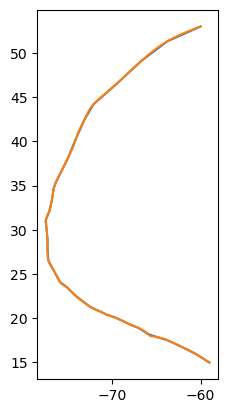

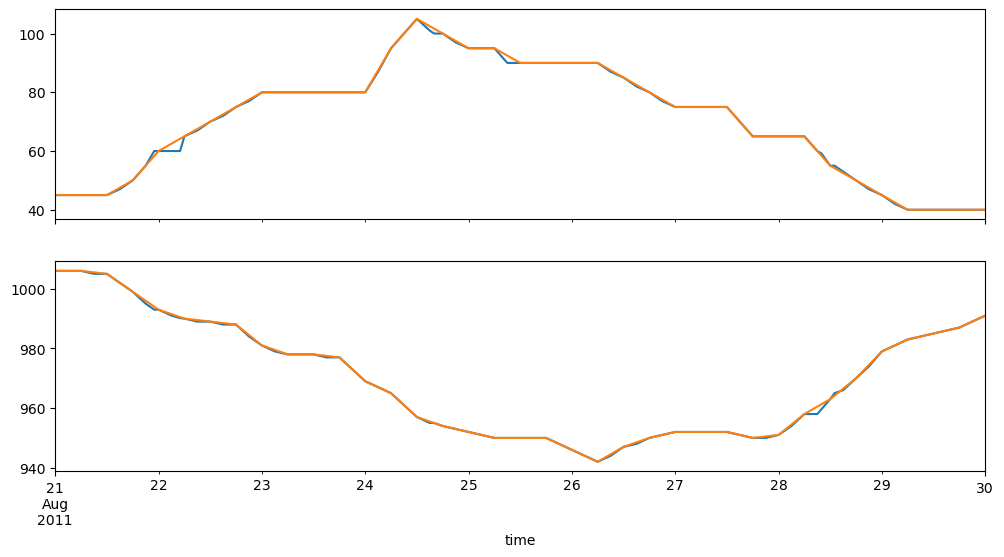

In [91]:
filein = r'/mnt/drive1/Insyncs/NCSU/thesis/data/tracks/irene/bal092011.dat'
trackIrene = ibtracks2fort22(filein, filein+'.remove', removeDup=True)

fig, ax = plt.subplots()
ax.plot(trackIrene.loc[:, 'lon'], trackIrene.loc[:, 'lat'])
ax.plot(dctTracks['IRENE'].loc[:, 'lon'], dctTracks['IRENE'].loc[:, 'lat'])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (12, 6), sharex = True, nrows = 2)
dctTracks['IRENE']['max_sustained_wind'].plot(ax = ax[0])
trackIrene['wind_speed'].plot(ax = ax[0])
dctTracks['IRENE']['central_pressure'].plot(ax = ax[1])
trackIrene['pressure'].plot(ax = ax[1])


<Axes: xlabel='time'>

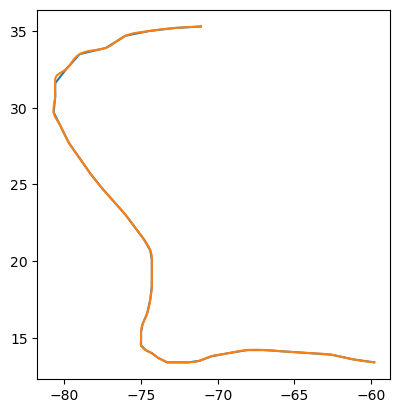

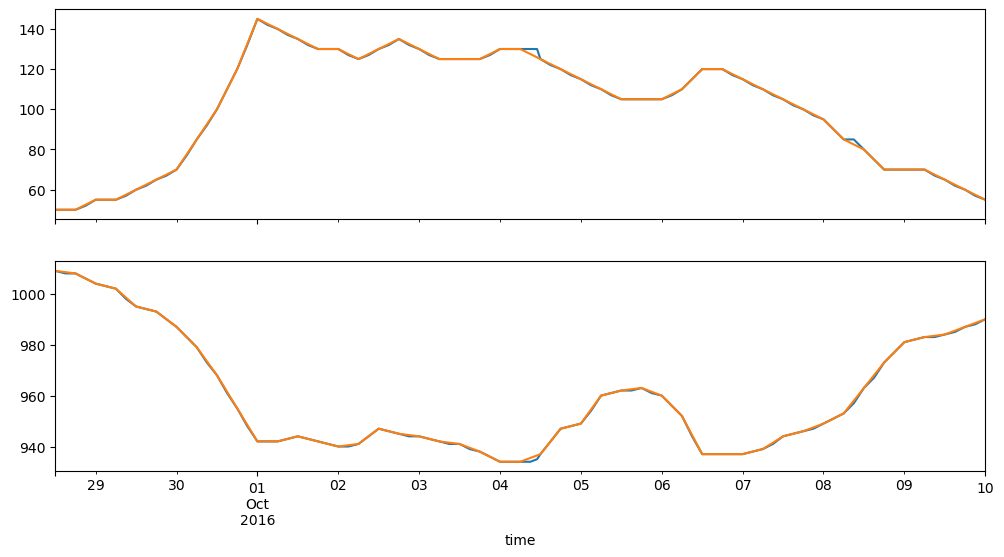

In [92]:
filein = r'/mnt/drive1/Insyncs/NCSU/thesis/data/tracks/matthew/bal142016.dat'
track = ibtracks2fort22(filein, filein+'.remove', removeDup=True)
storm = 'MATTHEW'

fig, ax = plt.subplots()
ax.plot(track.loc[:, 'lon'], track.loc[:, 'lat'])
ax.plot(dctTracks[storm].loc[:, 'lon'], dctTracks[storm].loc[:, 'lat'])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (12, 6), sharex = True, nrows = 2)
dctTracks[storm]['max_sustained_wind'].plot(ax = ax[0])
track['wind_speed'].plot(ax = ax[0])
dctTracks[storm]['central_pressure'].plot(ax = ax[1])
track['pressure'].plot(ax = ax[1])


<Axes: xlabel='time'>

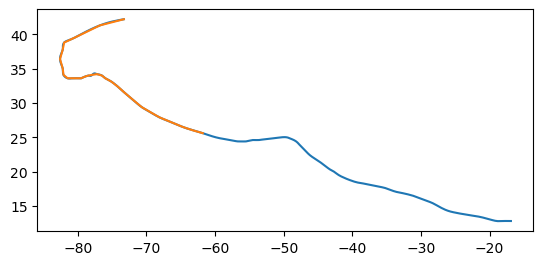

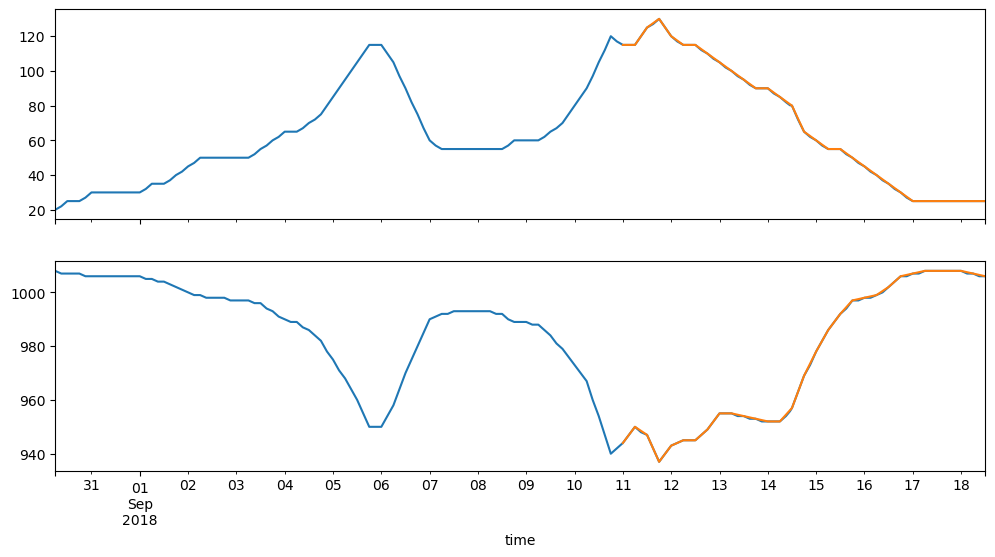

In [94]:
filein = r'/mnt/drive1/Insyncs/NCSU/thesis/data/tracks/florence/fort.22'
track = ibtracks2fort22(filein, filein+'.remove', removeDup=True)
storm = 'FLORENCE'

fig, ax = plt.subplots()
ax.plot(dctTracks[storm].loc[:, 'lon'], dctTracks[storm].loc[:, 'lat'])
ax.plot(track.loc[:, 'lon'], track.loc[:, 'lat'])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (12, 6), sharex = True, nrows = 2)
dctTracks[storm]['max_sustained_wind'].plot(ax = ax[0])
track['wind_speed'].plot(ax = ax[0])
dctTracks[storm]['central_pressure'].plot(ax = ax[1])
track['pressure'].plot(ax = ax[1])


<Axes: xlabel='time'>

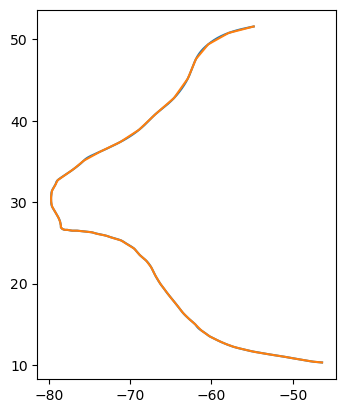

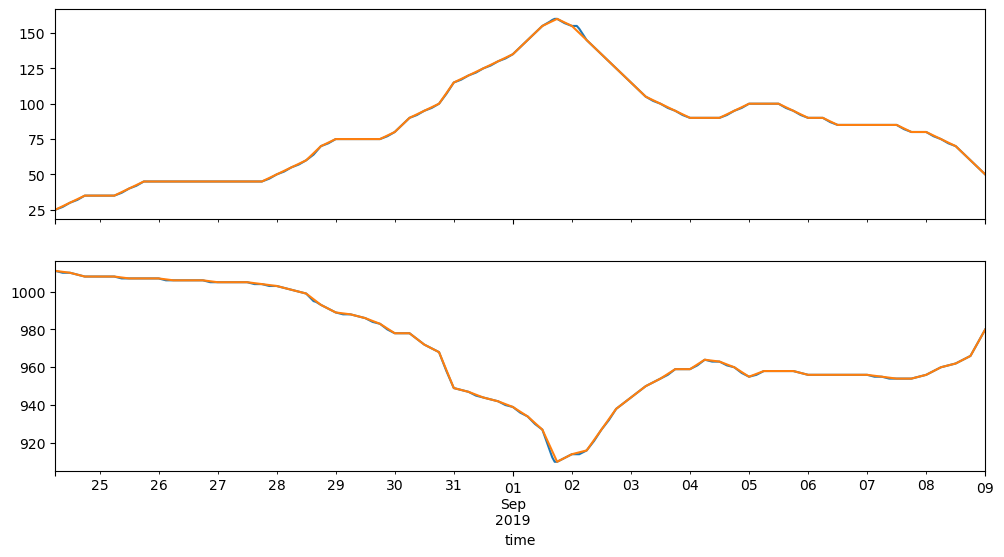

In [95]:
filein = r'/mnt/drive1/Insyncs/NCSU/thesis/data/tracks/dorian/bal052019.dat'
track = ibtracks2fort22(filein, filein+'.remove', removeDup=True)
storm = 'DORIAN'

fig, ax = plt.subplots()
ax.plot(dctTracks[storm].loc[:, 'lon'], dctTracks[storm].loc[:, 'lat'])
ax.plot(track.loc[:, 'lon'], track.loc[:, 'lat'])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (12, 6), sharex = True, nrows = 2)
dctTracks[storm]['max_sustained_wind'].plot(ax = ax[0])
track['wind_speed'].plot(ax = ax[0])
dctTracks[storm]['central_pressure'].plot(ax = ax[1])
track['pressure'].plot(ax = ax[1])


<Axes: xlabel='time'>

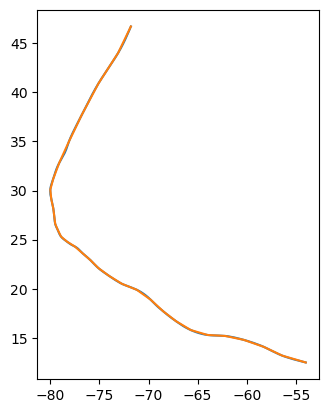

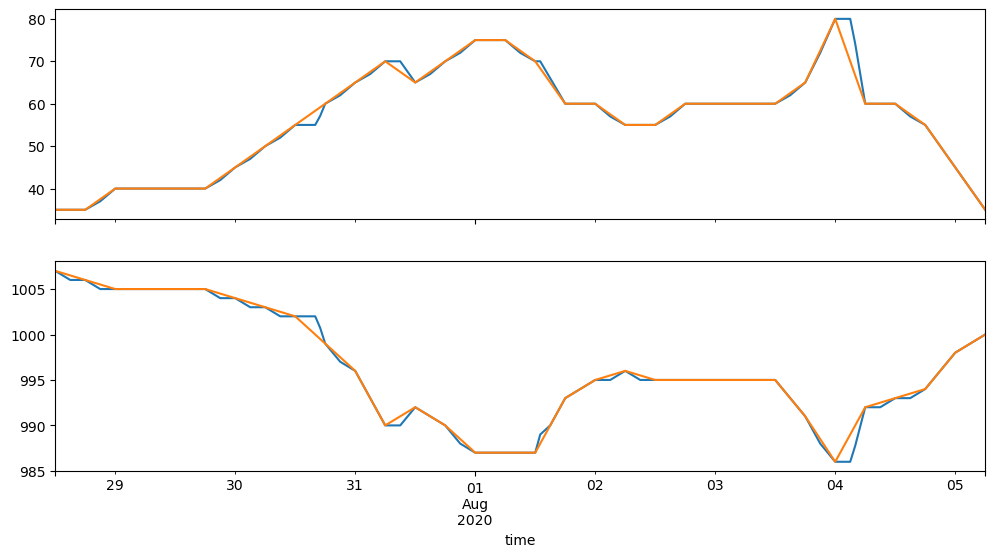

In [96]:
filein = r'/mnt/drive1/Insyncs/NCSU/thesis/data/tracks/isaias/bal092020.dat'
track = ibtracks2fort22(filein, filein+'.remove', removeDup=True)
storm = 'ISAIAS'

fig, ax = plt.subplots()
ax.plot(dctTracks[storm].loc[:, 'lon'], dctTracks[storm].loc[:, 'lat'])
ax.plot(track.loc[:, 'lon'], track.loc[:, 'lat'])
ax.set_aspect('equal')

fig, ax = plt.subplots(figsize = (12, 6), sharex = True, nrows = 2)
dctTracks[storm]['max_sustained_wind'].plot(ax = ax[0])
track['wind_speed'].plot(ax = ax[0])
dctTracks[storm]['central_pressure'].plot(ax = ax[1])
track['pressure'].plot(ax = ax[1])


#### Apply zero padding to match training dataset dimensions

In [17]:
## zero padding data

maxlen = 235

with open(path/'tracksNC_with100perturbations_predTides_processed.pkl', 'rb') as fin:
    dctTracksProcessed = pickle.load(fin)

inpArrPadded = []
for k in dctTracksProcessed.keys():
    aux = dctTracksProcessed[k]
    padLength = maxlen - len(aux)
    auxPadded = np.pad(aux.values, ((padLength, 0), (0, 0)), mode = 'constant')
    inpArrPadded.append(auxPadded)

inpArrPadded = np.asarray(inpArrPadded, dtype = float)
np.save(path/f'tracksNCshortened_with100perturbations_predTides_processed_zeroPadded.npy', inpArrPadded, allow_pickle=False)

In [18]:
### scale data
inpArray = np.load(path/f'tracksNCshortened_with100perturbations_predTides_processed_zeroPadded.npy')
pathinScaler = Path(r'../models/NNmodel/inputs/random_split')
scaler = pickle.load(open(pathinScaler/'standarScaler_augmentedAllX50_def.pkl', 'rb'))

inpArray_res = inpArray.reshape(inpArray.shape[0] * inpArray.shape[1], inpArray.shape[2])
mask = inpArray_res == 0
inpArray_res[mask] = np.nan
inpArray_res_sc = scaler.transform(inpArray_res)
inpArray_res_sc = np.nan_to_num(inpArray_res_sc, nan=-9999)
inpArray_sc = inpArray_res_sc.reshape(inpArray.shape)
print(inpArray_sc.shape)
np.save(path/f'tracksNCshortened_with100perturbations_predTides_processed_zeroPadded_scaled.npy', inpArray_sc, allow_pickle=False)

(700, 235, 37)


In [13]:
X_test_sc = np.load(r'../models/NNmodel/inputs/random_split/X_test_standardScaled_allInputs_augmentedAllX50.npy')

In [14]:
dfSample = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN/dct_tracksAll_batch02_lengthCorr_tides_resampled_SAMPLE.csv',
                       index_col = 0)
st = 'Duck'
cols = ['wind_speed', 'pressure', 'rad_to_max_ws', 'forward_speed_u', 'forward_speed_v',
        f'dist_to_{st.lower()}', f'{st}', 'wind_speed_fft', 'pressure_fft', 'rad_to_max_ws_fft',
        'forward_speed_u_fft', 'forward_speed_v_fft']

idx_cols = [list(dfSample).index(x) for x in cols]
X_test_sc2 = X_test_sc[0, :, idx_cols]
inpArray_sc2 = inpArray_sc[0, :, idx_cols]

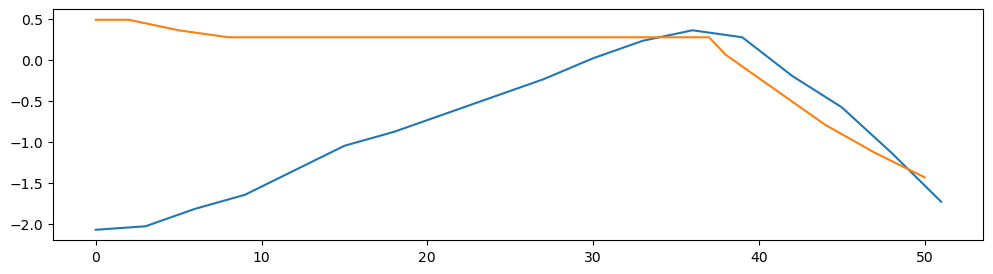

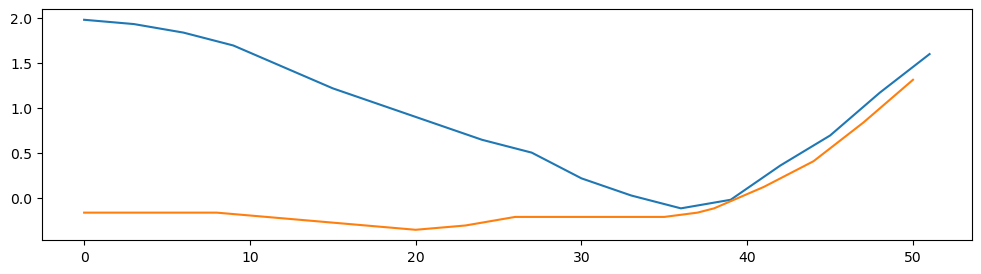

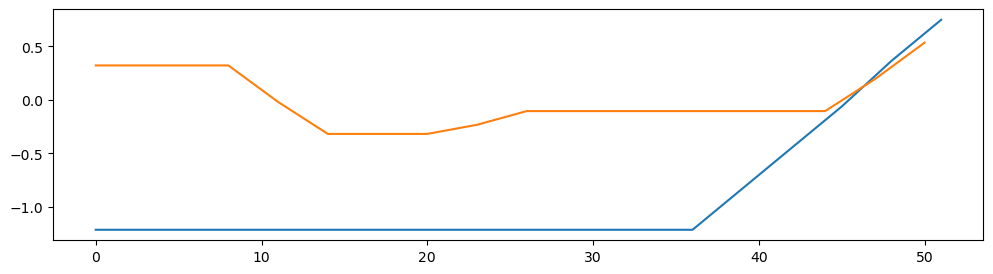

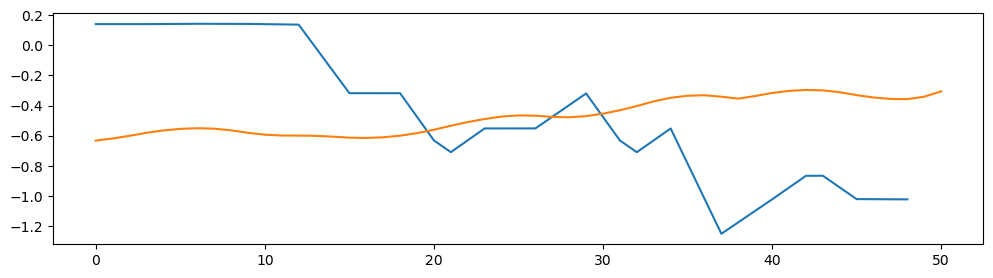

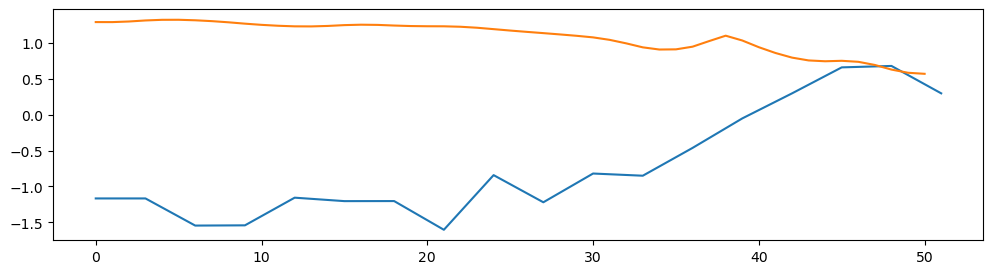

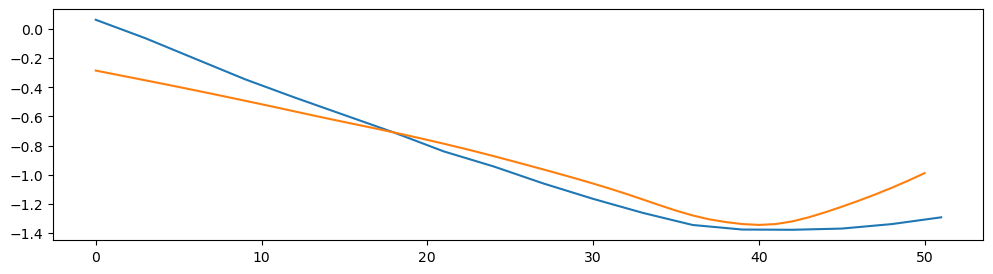

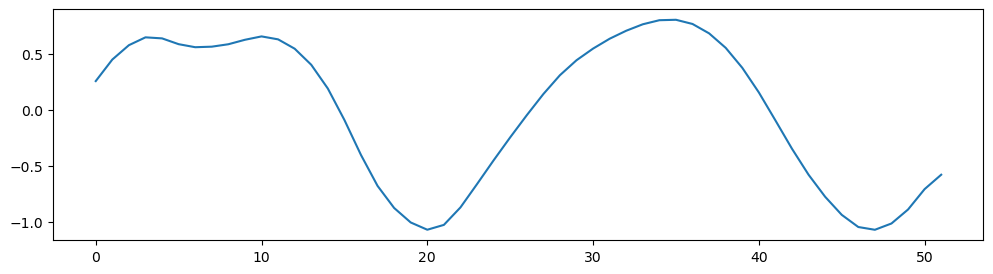

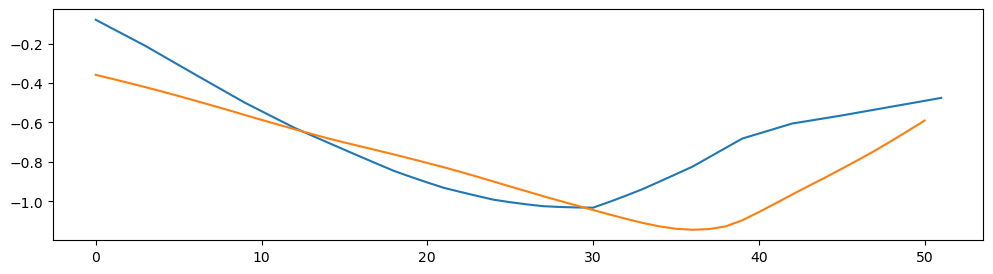

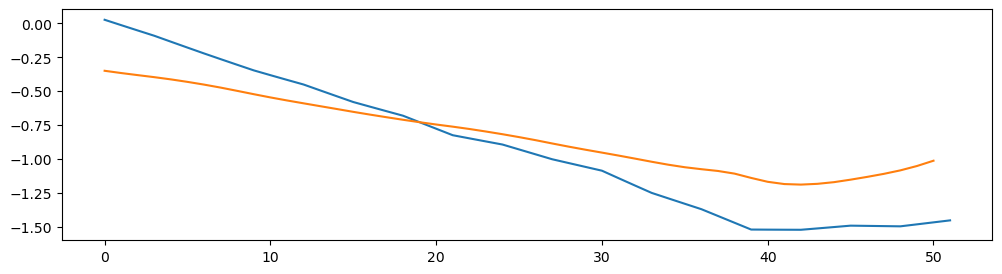

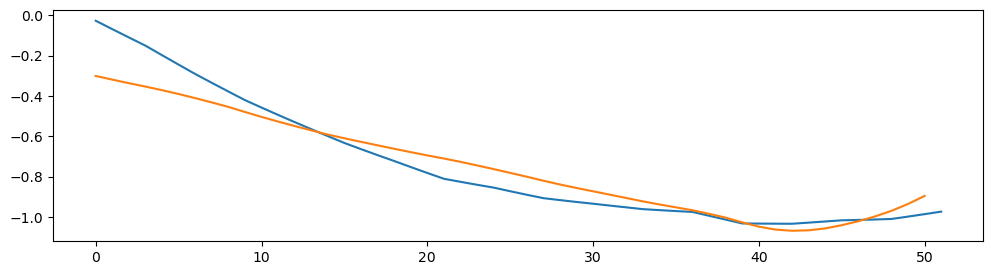

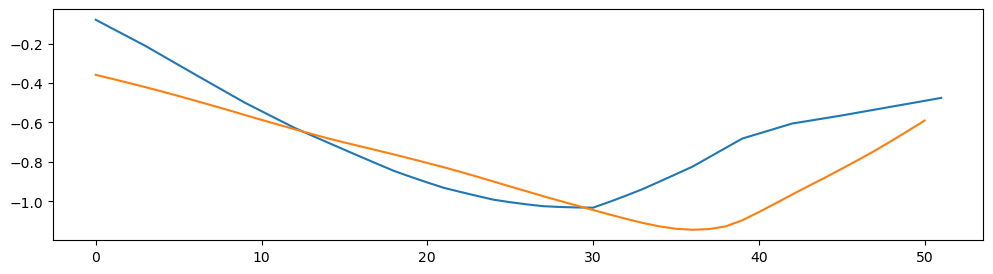

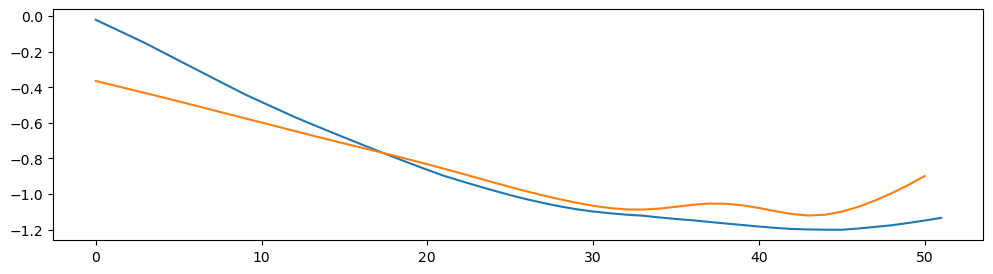

In [24]:
for i in range(12):
    fig, ax = plt.subplots(figsize = (12, 3))
    ax.plot(X_test_sc2[i, :][X_test_sc2[i, :] > -100])
    ax.plot(inpArray_sc2[i, :][inpArray_sc2[i, :] > -100])